# Exploratory Analysis - EDA

Dataprep.EDA
* Main Site - https://dataprep.ai/
* Docs - https://docs.dataprep.ai/user_guide/eda/introduction.html

## Table of Contents

[EDA DF](#eda_df)
* [Basic Data Overview](#basic_data_overview)  
* [General Exploration - Dataprep.EDA](#dataprep)  
* [Specific Questions:](#specific_questions)
    * [Average Point Spread Error Per Game Over Time](#apsepgot)  

[Game Records](#game_records)
* [Data Overview](#data_overview)  
* [Specific Questions:](#specific_questions_2)
    * [Model Performance Over Time](#mpot)
    * [Distributions of Model Predictions, Vegas Predictions, and Game Results](#dmpvpgp)
    * [Overall Winning vs. Losing Predictions](#owvlp)
    * [Win Percentage vs. Prediction Margin](#wpvpm)
* [Game Score and Component Score Accuracy](#gscsa)
    * [Overall](#overall)
    * [Game Score](#gamescore)
    * [ML Predictions](#ml)
    * [DL Predictions](#dl)
    * [Covers Consensus](#covers)
    * [FiveThirtyEight Raptor](#raptor)

## Imports and Global Settings

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')
from passkeys import RDS_ENDPOINT, RDS_PASSWORD

# Pandas Settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.max_info_columns = 200
pd.options.display.precision = 5

# Graphing Settings
sns.set_theme()

NumExpr defaulting to 4 threads.


## Database Connection

In [2]:
username = 'postgres'
password = RDS_PASSWORD
endpoint = RDS_ENDPOINT
database = 'nba_betting'
port = '5432'

connection = create_engine(f'postgresql+psycopg2://{username}:{password}@{endpoint}/{database}').connect()

### Datasets

In [3]:
game_records = pd.read_sql_table('game_records', connection)
eda_df = pd.read_sql_table('combined_inbound_data', connection)

<a id='eda_df'></a>

# EDA_DF

## Setting up Targets and Features

In [4]:
eda_df.insert(10, 'pred_home_margin', 0 - eda_df['home_spread'])

In [5]:
eda_df.insert(11, 'actual_home_margin', eda_df['home_score'] - eda_df['away_score'])

In [6]:
eda_df.insert(12, 'spread_miss', eda_df['actual_home_margin'] - eda_df['pred_home_margin'])

In [7]:
eda_df.insert(13, 'abs_spread_miss', eda_df['spread_miss'].abs())

<a id='basic_data_overview'></a>

## Basic Data Overview

In [8]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9431 entries, 0 to 9430
Columns: 1245 entries, game_id to total_rating_538
dtypes: datetime64[ns](2), float64(1236), object(7)
memory usage: 89.6+ MB


In [9]:
eda_df.describe()

,home_score,away_score,home_spread,pred_home_margin,actual_home_margin,spread_miss,abs_spread_miss,fd_line_home,fd_line_price_home,fd_line_away,fd_line_price_away,dk_line_home,dk_line_price_home,dk_line_away,dk_line_price_away,covers_consensus_home,covers_consensus_away,gp,win,loss,w_pct,mins,pts,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,tov,stl,blk,blka,pf,pfd,p_m,gp_rank,gp_vla,gp_vla_std,win_rank,win_vla,win_vla_std,loss_rank,loss_vla,loss_vla_std,w_pct_rank,w_pct_vla,w_pct_vla_std,mins_rank,mins_vla,mins_vla_std,pts_rank,pts_vla,pts_vla_std,fgm_rank,fgm_vla,fgm_vla_std,fga_rank,fga_vla,fga_vla_std,fg_pct_rank,fg_pct_vla,fg_pct_vla_std,fg3m_rank,fg3m_vla,fg3m_vla_std,fg3a_rank,fg3a_vla,fg3a_vla_std,fg3_pct_rank,fg3_pct_vla,fg3_pct_vla_std,ftm_rank,ftm_vla,ftm_vla_std,fta_rank,fta_vla,fta_vla_std,ft_pct_rank,ft_pct_vla,ft_pct_vla_std,oreb_rank,oreb_vla,oreb_vla_std,dreb_rank,dreb_vla,dreb_vla_std,reb_rank,reb_vla,reb_vla_std,ast_rank,ast_vla,ast_vla_std,tov_rank,tov_vla,tov_vla_std,stl_rank,stl_vla,stl_vla_std,blk_rank,blk_vla,blk_vla_std,blka_rank,blka_vla,blka_vla_std,pf_rank,pf_vla,pf_vla_std,pfd_rank,pfd_vla,pfd_vla_std,p_m_rank,p_m_vla,p_m_vla_std,gp_opp,win_opp,loss_opp,w_pct_opp,mins_opp,pts_opp,fgm_opp,fga_opp,fg_pct_opp,fg3m_opp,fg3a_opp,fg3_pct_opp,ftm_opp,fta_opp,ft_pct_opp,oreb_opp,dreb_opp,reb_opp,ast_opp,tov_opp,stl_opp,blk_opp,blka_opp,pf_opp,pfd_opp,p_m_opp,gp_rank_opp,gp_vla_opp,gp_vla_std_opp,win_rank_opp,win_vla_opp,win_vla_std_opp,loss_rank_opp,loss_vla_opp,loss_vla_std_opp,w_pct_rank_opp,w_pct_vla_opp,w_pct_vla_std_opp,mins_rank_opp,mins_vla_opp,mins_vla_std_opp,pts_rank_opp,pts_vla_opp,pts_vla_std_opp,fgm_rank_opp,fgm_vla_opp,fgm_vla_std_opp,fga_rank_opp,fga_vla_opp,fga_vla_std_opp,fg_pct_rank_opp,fg_pct_vla_opp,fg_pct_vla_std_opp,fg3m_rank_opp,fg3m_vla_opp,fg3m_vla_std_opp,fg3a_rank_opp,fg3a_vla_opp,fg3a_vla_std_opp,fg3_pct_rank_opp,fg3_pct_vla_opp,fg3_pct_vla_std_opp,ftm_rank_opp,ftm_vla_opp,ftm_vla_std_opp,fta_rank_opp,fta_vla_opp,fta_vla_std_opp,ft_pct_rank_opp,ft_pct_vla_opp,ft_pct_vla_std_opp,oreb_rank_opp,oreb_vla_opp,oreb_vla_std_opp,dreb_rank_opp,dreb_vla_opp,dreb_vla_std_opp,reb_rank_opp,reb_vla_opp,reb_vla_std_opp,ast_rank_opp,ast_vla_opp,ast_vla_std_opp,tov_rank_opp,tov_vla_opp,tov_vla_std_opp,stl_rank_opp,stl_vla_opp,stl_vla_std_opp,blk_rank_opp,blk_vla_opp,blk_vla_std_opp,blka_rank_opp,blka_vla_opp,blka_vla_std_opp,pf_rank_opp,pf_vla_opp,pf_vla_std_opp,pfd_rank_opp,pfd_vla_opp,pfd_vla_std_opp,p_m_rank_opp,p_m_vla_opp,p_m_vla_std_opp,offrtg,defrtg,netrtg,ast_pct,ast_v_tov,ast_ratio,oreb_pct,dreb_pct,reb_pct,tov_pct,efg_pct,ts_pct,pace,pie,poss,offrtg_rank,offrtg_vla,offrtg_vla_std,defrtg_rank,defrtg_vla,defrtg_vla_std,netrtg_rank,netrtg_vla,netrtg_vla_std,ast_pct_rank,...,opp_fga_ra_vla,opp_fga_ra_vla_std,opp_fg_pct_ra_rank,opp_fg_pct_ra_vla,opp_fg_pct_ra_vla_std,opp_fgm_paint_rank,opp_fgm_paint_vla,opp_fgm_paint_vla_std,opp_fga_paint_rank,opp_fga_paint_vla,opp_fga_paint_vla_std,opp_fg_pct_paint_rank,opp_fg_pct_paint_vla,opp_fg_pct_paint_vla_std,opp_fgm_mr_rank,opp_fgm_mr_vla,opp_fgm_mr_vla_std,opp_fga_mr_rank,opp_fga_mr_vla,opp_fga_mr_vla_std,opp_fg_pct_mr_rank,opp_fg_pct_mr_vla,opp_fg_pct_mr_vla_std,opp_fgm_lc3_rank,opp_fgm_lc3_vla,opp_fgm_lc3_vla_std,opp_fga_lc3_rank,opp_fga_lc3_vla,opp_fga_lc3_vla_std,opp_fg_pct_lc3_rank,opp_fg_pct_lc3_vla,opp_fg_pct_lc3_vla_std,opp_fgm_rc3_rank,opp_fgm_rc3_vla,opp_fgm_rc3_vla_std,opp_fga_rc3_rank,opp_fga_rc3_vla,opp_fga_rc3_vla_std,opp_fg_pct_rc3_rank,opp_fg_pct_rc3_vla,opp_fg_pct_rc3_vla_std,opp_fgm_c3_rank,opp_fgm_c3_vla,opp_fgm_c3_vla_std,opp_fga_c3_rank,opp_fga_c3_vla,opp_fga_c3_vla_std,opp_fg_pct_c3_rank,opp_fg_pct_c3_vla,opp_fg_pct_c3_vla_std,opp_fgm_atb3_rank,opp_fgm_atb3_vla,opp_fgm_atb3_vla_std,opp_fga_atb3_rank,opp_fga_atb3_vla,opp_fga_atb3_vla_std,opp_fg_pct_atb3_rank,opp_fg_pct_atb3_vla,opp_fg_pct_atb3_vla_std,opp_fgm_ra_opp,opp_fga_ra_opp,opp_fg_pct_ra_opp,opp_fgm_paint_opp,opp_fga_paint_opp,opp_fg_pct_paint_opp,opp

In [10]:
eda_df.head()

,game_id,game_date,home_team,away_team,home_score,away_score,home_result,league_year,pred_date,home_spread,pred_home_margin,actual_home_margin,spread_miss,abs_spread_miss,home_spread_result,covers_game_url,fd_line_home,fd_line_price_home,fd_line_away,fd_line_price_away,dk_line_home,dk_line_price_home,dk_line_away,dk_line_price_away,covers_consensus_home,covers_consensus_away,gp,win,loss,w_pct,mins,pts,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,tov,stl,blk,blka,pf,pfd,p_m,gp_rank,gp_vla,gp_vla_std,win_rank,win_vla,win_vla_std,loss_rank,loss_vla,loss_vla_std,w_pct_rank,w_pct_vla,w_pct_vla_std,mins_rank,mins_vla,mins_vla_std,pts_rank,pts_vla,pts_vla_std,fgm_rank,fgm_vla,fgm_vla_std,fga_rank,fga_vla,fga_vla_std,fg_pct_rank,fg_pct_vla,fg_pct_vla_std,fg3m_rank,fg3m_vla,fg3m_vla_std,fg3a_rank,fg3a_vla,fg3a_vla_std,fg3_pct_rank,fg3_pct_vla,fg3_pct_vla_std,ftm_rank,ftm_vla,ftm_vla_std,fta_rank,fta_vla,fta_vla_std,ft_pct_rank,ft_pct_vla,ft_pct_vla_std,oreb_rank,oreb_vla,oreb_vla_std,dreb_rank,dreb_vla,dreb_vla_std,reb_rank,reb_vla,reb_vla_std,ast_rank,ast_vla,ast_vla_std,tov_rank,tov_vla,tov_vla_std,stl_rank,stl_vla,stl_vla_std,blk_rank,blk_vla,blk_vla_std,blka_rank,blka_vla,blka_vla_std,pf_rank,pf_vla,pf_vla_std,pfd_rank,pfd_vla,pfd_vla_std,p_m_rank,p_m_vla,p_m_vla_std,gp_opp,win_opp,loss_opp,w_pct_opp,mins_opp,pts_opp,fgm_opp,fga_opp,fg_pct_opp,fg3m_opp,fg3a_opp,fg3_pct_opp,ftm_opp,fta_opp,ft_pct_opp,oreb_opp,dreb_opp,reb_opp,ast_opp,tov_opp,stl_opp,blk_opp,blka_opp,pf_opp,pfd_opp,p_m_opp,gp_rank_opp,gp_vla_opp,gp_vla_std_opp,win_rank_opp,win_vla_opp,win_vla_std_opp,loss_rank_opp,loss_vla_opp,loss_vla_std_opp,w_pct_rank_opp,w_pct_vla_opp,w_pct_vla_std_opp,mins_rank_opp,mins_vla_opp,mins_vla_std_opp,pts_rank_opp,pts_vla_opp,pts_vla_std_opp,fgm_rank_opp,fgm_vla_opp,fgm_vla_std_opp,fga_rank_opp,fga_vla_opp,fga_vla_std_opp,fg_pct_rank_opp,fg_pct_vla_opp,fg_pct_vla_std_opp,fg3m_rank_opp,fg3m_vla_opp,fg3m_vla_std_opp,fg3a_rank_opp,fg3a_vla_opp,fg3a_vla_std_opp,fg3_pct_rank_opp,fg3_pct_vla_opp,fg3_pct_vla_std_opp,ftm_rank_opp,ftm_vla_opp,ftm_vla_std_opp,fta_rank_opp,fta_vla_opp,fta_vla_std_opp,ft_pct_rank_opp,ft_pct_vla_opp,ft_pct_vla_std_opp,oreb_rank_opp,oreb_vla_opp,oreb_vla_std_opp,dreb_rank_opp,dreb_vla_opp,dreb_vla_std_opp,reb_rank_opp,reb_vla_opp,reb_vla_std_opp,ast_rank_opp,ast_vla_opp,ast_vla_std_opp,tov_rank_opp,tov_vla_opp,tov_vla_std_opp,stl_rank_opp,stl_vla_opp,stl_vla_std_opp,blk_rank_opp,blk_vla_opp,blk_vla_std_opp,blka_rank_opp,blka_vla_opp,blka_vla_std_opp,pf_rank_opp,pf_vla_opp,pf_vla_std_opp,pfd_rank_opp,pfd_vla_opp,pfd_vla_std_opp,p_m_rank_opp,p_m_vla_opp,p_m_vla_std_opp,offrtg,defrtg,netrtg,ast_pct,ast_v_tov,ast_ratio,oreb_pct,dreb_pct,reb_pct,tov_pct,efg_pct,ts_pct,pace,pie,poss,offrtg_rank,...,opp_fga_ra_vla,opp_fga_ra_vla_std,opp_fg_pct_ra_rank,opp_fg_pct_ra_vla,opp_fg_pct_ra_vla_std,opp_fgm_paint_rank,opp_fgm_paint_vla,opp_fgm_paint_vla_std,opp_fga_paint_rank,opp_fga_paint_vla,opp_fga_paint_vla_std,opp_fg_pct_paint_rank,opp_fg_pct_paint_vla,opp_fg_pct_paint_vla_std,opp_fgm_mr_rank,opp_fgm_mr_vla,opp_fgm_mr_vla_std,opp_fga_mr_rank,opp_fga_mr_vla,opp_fga_mr_vla_std,opp_fg_pct_mr_rank,opp_fg_pct_mr_vla,opp_fg_pct_mr_vla_std,opp_fgm_lc3_rank,opp_fgm_lc3_vla,opp_fgm_lc3_vla_std,opp_fga_lc3_rank,opp_fga_lc3_vla,opp_fga_lc3_vla_std,opp_fg_pct_lc3_rank,opp_fg_pct_lc3_vla,opp_fg_pct_lc3_vla_std,opp_fgm_rc3_rank,opp_fgm_rc3_vla,opp_fgm_rc3_vla_std,opp_fga_rc3_rank,opp_fga_rc3_vla,opp_fga_rc3_vla_std,opp_fg_pct_rc3_rank,opp_fg_pct_rc3_vla,opp_fg_pct_rc3_vla_std,opp_fgm_c3_rank,opp_fgm_c3_vla,opp_fgm_c3_vla_std,opp_fga_c3_rank,opp_fga_c3_vla,opp_fga_c3_vla_std,opp_fg_pct_c3_rank,opp_fg_pct_c3_vla,opp_fg_pct_c3_vla_std,opp_fgm_atb3_rank,opp_fgm_atb3_vla,opp_fgm_atb3_vla_std,opp_fga_atb3_rank,opp_fga_atb3_vla,opp_fga_atb3_vla_std,opp_fg_pct_atb3_rank,opp_fg_pct_atb3_vla,opp_fg_pct_atb3_vla_std,opp_fgm_ra_opp,opp_fga_ra_opp,opp_fg_pct_ra_opp,opp_fgm_paint_opp,opp_fga_paint_opp,opp_fg_pct_paint_opp,opp_fgm_mr_

<a id=dataprep></a>

## Dataprep.EDA General Exploration

In [11]:
# Excluding live odds data.
# Low amounts of non-nulls causing divide by zero errors in dataprep report creation.

# dataprep_report = create_report(eda_df.drop(columns=['open_line_home',
#        'open_line_away', 'fd_line_home', 'fd_line_price_home', 'fd_line_away',
#        'fd_line_price_away', 'dk_line_home', 'dk_line_price_home',
#        'dk_line_away', 'dk_line_price_away', 'covers_consenses_home',
#        'covers_consenses_away']), title='NBA Betting Data Overview')

In [12]:
# dataprep_report.show_browser()

In [13]:
# plot(eda_df)

## Comparing Features to Target

In [14]:
# feature_to_compare = 'away_expected_wins'

In [15]:
# plot(eda_df, feature_to_compare, 'abs_spread_miss')

In [16]:
# plot_correlation(eda_df, feature_to_compare, 'abs_spread_miss')

<a id=specific_questions></a>

## Specific Questions

<a id=apsepgot></a>

### Average Point Spread Error Per Game Over Time

In [17]:
spread_miss_data = eda_df.groupby(eda_df.game_date.dt.year).mean()

In [18]:
spread_miss_data['abs_spread_miss']

game_date
2014     9.14579
2015     9.17938
2016     9.30338
2017     9.71621
2018     9.65188
2019     9.65240
2020    10.24829
2021    10.50633
2022    10.54252
Name: abs_spread_miss, dtype: float64

In [19]:
round(eda_df['abs_spread_miss'].mean(), 2)

9.79

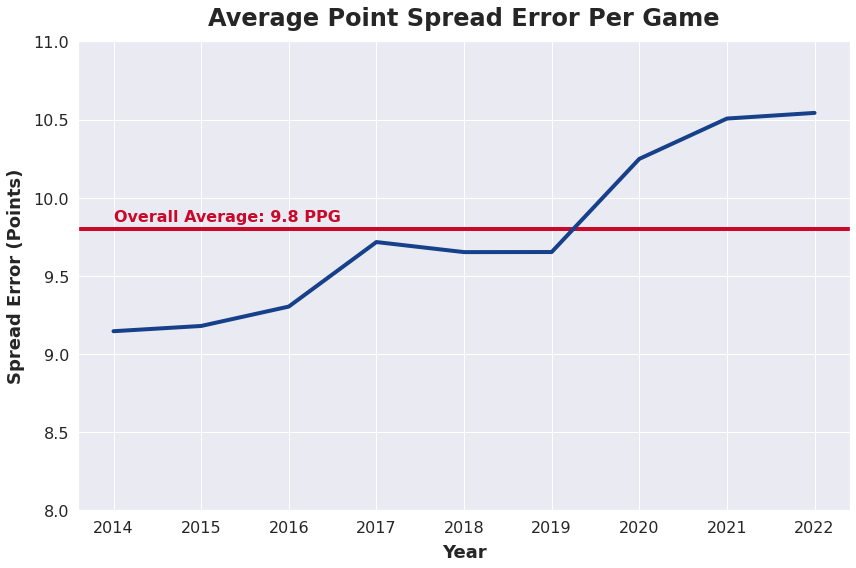

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Average Point Spread Error Per Game', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Spread Error (Points)', fontsize=18, labelpad=8, fontweight='bold')
# ax.set_xlim()
ax.set_ylim(top=11, bottom=8)
ax.axhline(9.8, color='#C9082A', linewidth=4)
ax.text(x=2014.01, y=9.85, s='Overall Average: 9.8 PPG', color='#C9082A', fontsize=16, fontweight='bold')

sns.lineplot(x = 'game_date', y = 'abs_spread_miss', data = spread_miss_data, ax=ax,
             linewidth=4, color='#17408B')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

image_name = 'average_point_spread_error_per_game_over_time'
# plt.savefig(f'../images/{image_name}.png', dpi=300, bbox_inches='tight')

<a id=game_records></a>

# Game Records

## Setting Up Features, Data Manipulation

In [21]:
game_records['vegas_hv_pred'] = game_records['home_line'].apply(lambda x: -x)

In [22]:
game_records['ml_hv_pred'] = game_records['ml_reg_prediction']
game_records['dl_hv_pred'] = game_records['dl_reg_prediction']

In [23]:
game_records['vegas_miss'] = game_records.apply(lambda x: abs(x['game_result'] - x['vegas_hv_pred']),
                                                axis=1)

In [24]:
game_records['model_miss_ml'] = game_records.apply(lambda x: abs(x['game_result'] - x['ml_hv_pred']),
                                                   axis=1)
game_records['model_miss_dl'] = game_records.apply(lambda x: abs(x['game_result'] - x['dl_hv_pred']),
                                                   axis=1)

In [25]:
game_records['ml_model_v_vegas'] = game_records.apply(lambda x: 'vegas' if x['vegas_miss'] < x['model_miss_ml'] else 'ml_model', axis=1)
game_records['dl_model_v_vegas'] = game_records.apply(lambda x: 'vegas' if x['vegas_miss'] < x['model_miss_dl'] else 'dl_model', axis=1)

In [26]:
game_records['ml_pred_line_margin'] = game_records['ml_hv_pred'] - game_records['vegas_hv_pred']
game_records['dl_pred_line_margin'] = game_records['dl_hv_pred'] - game_records['vegas_hv_pred']

In [27]:
game_records['game_result_direction'] = game_records.apply(lambda x: 'Home' if x['game_result'] >= x['vegas_hv_pred'] else 'Away', axis=1)
game_records['covers_pred_direction'] = game_records['covers_home_score'].apply(lambda x: x if pd.isnull(x) else ('Home' if x >= 50 else 'Away'))
game_records['raptor_pred_direction'] = game_records['raptor_home_score'].apply(lambda x: x if pd.isnull(x) else ('Home' if x >= 50 else 'Away'))
game_records['ml_pred_direction'] = game_records['ml_home_score'].apply(lambda x: 'Home' if x >= 50 else 'Away')
game_records['dl_pred_direction'] = game_records['dl_home_score'].apply(lambda x: 'Home' if x >= 50 else 'Away')

<a id=data_overview></a>

## Data Overview

In [28]:
game_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   game_id                9426 non-null   object        
 1   game_info              9426 non-null   object        
 2   date                   9426 non-null   datetime64[ns]
 3   home                   9426 non-null   object        
 4   away                   9426 non-null   object        
 5   home_line              9426 non-null   float64       
 6   ml_home_score          9426 non-null   float64       
 7   dl_home_score          9426 non-null   float64       
 8   covers_home_score      159 non-null    float64       
 9   raptor_home_score      4667 non-null   float64       
 10  game_score             9426 non-null   float64       
 11  game_score_direction   9426 non-null   object        
 12  bet_direction_vote     9426 non-null   object        
 13  rec

In [29]:
game_records.describe()

,home_line,ml_home_score,dl_home_score,covers_home_score,raptor_home_score,game_score,rec_bet_amount,home_score,away_score,game_result,ml_reg_prediction,dl_reg_prediction,vegas_hv_pred,ml_hv_pred,dl_hv_pred,vegas_miss,model_miss_ml,model_miss_dl,ml_pred_line_margin,dl_pred_line_margin
count,9426.00000,9426.00000,9426.00000,159.00000,4667.00000,9426.00000,9426.00000,9415.00000,9415.00000,9415.00000,9426.00000,9426.00000,9426.00000,9426.00000,9426.00000,9415.00000,9415.00000,9415.00000,9426.00000,9426.00000
mean,-2.41799,49.91254,49.97460,52.15723,54.41163,57.46114,6.58309,108.66192,106.38003,2.28189,2.28664,2.32880,2.41799,2.28664,2.32880,9.79819,9.81509,9.71629,-0.13135,-0.08919
std,6.69701,10.65934,15.58181,12.01504,8.64298,5.68961,7.67086,12.78420,12.97781,14.11528,6.02549,6.52556,6.69701,6.02549,6.52556,7.87935,7.87424,7.71637,0.91930,3.60575
min,-21.50000,13.03000,8.09154,28.00000,3.10772,50.00336,0.00000,64.00000,66.00000,-57.00000,-16.92759,-17.95204,-17.50000,-16.92759,-17.95204,0.00000,0.00054,0.01110,-4.10460,-17.36544
25%,-7.50000,42.74000,38.48508,42.00000,49.19064,52.90938,0.00000,100.00000,98.00000,-7.00000,-2.48693,-2.14416,-3.00000,-2.48693,-2.14416,3.50000,3.72896,3.68303,-0.75601,-2.32695
50%,-3.50000,49.97000,49.88234,54.00000,54.34803,56.27679,7.93000,108.00000,106.00000,3.00000,2.93243,2.42083,3.50000,2.93243,2.42083,8.00000,8.01217,7.98344,-0.19691,-0.07253
75%,3.00000,57.06000,61.28806,61.50000,59.64732,60.80087,7.93000,117.00000,115.00000,11.00000,6.65778,6.77951,7.50000,6.65778,6.77951,14.00000,14.03528,13.92751,0.49048,2.14320
max,17.50000,85.76000,93.54222,75.00000,99.38767,84.72414,39.65000,161.00000,168.00000,73.00000,20.67890,24.34181,21.50000,20.67890,24.34181,62.00000,63.38222,60.03968,4.28187,18.19967


In [30]:
game_records.head(50)

,game_id,game_info,date,home,away,home_line,ml_home_score,dl_home_score,covers_home_score,raptor_home_score,game_score,game_score_direction,bet_direction_vote,rec_bet_amount,home_score,away_score,game_result,ml_reg_prediction,dl_reg_prediction,vegas_hv_pred,ml_hv_pred,dl_hv_pred,vegas_miss,model_miss_ml,model_miss_dl,ml_model_v_vegas,dl_model_v_vegas,ml_pred_line_margin,dl_pred_line_margin,game_result_direction,covers_pred_direction,raptor_pred_direction,ml_pred_direction,dl_pred_direction
0,20150115MILNYK,/sport/basketball/nba/boxscore/39732,2015-01-15,MIL,NYK,-7.5,56.96,70.31786,NaN,NaN,63.63893,Home,Tie 2-2,7.93,95.0,79.0,16.0,6.13521,12.55748,7.5,6.13521,12.55748,8.5,9.86479,3.44252,vegas,dl_model,-1.36479,5.05748,Home,NaN,NaN,Home,Home
1,20141103BKNOKC,/sport/basketball/nba/boxscore/28838,2014-11-03,BKN,OKC,-7.0,61.90,52.61900,NaN,NaN,57.25950,Home,Tie 2-2,7.93,116.0,85.0,31.0,4.91906,2.75898,7.0,4.91906,2.75898,24.0,26.08094,28.24102,vegas,vegas,-2.08094,-4.24102,Home,NaN,NaN,Home,Home
2,20141103DALBOS,/sport/basketball/nba/boxscore/29081,2014-11-03,DAL,BOS,-9.5,34.49,47.40006,NaN,NaN,59.05497,Away,Away 4-0,7.93,118.0,113.0,5.0,9.13372,7.77325,9.5,9.13372,7.77325,4.5,4.13372,2.77325,ml_model,dl_model,-0.36628,-1.72675,Away,NaN,NaN,Away,Away
3,20141103DENSAC,/sport/basketball/nba/boxscore/28879,2014-11-03,DEN,SAC,-6.5,35.71,23.50515,NaN,NaN,70.39243,Away,Away 4-0,23.79,105.0,110.0,-5.0,5.49981,3.78326,6.5,5.49981,3.78326,11.5,10.49981,8.78326,ml_model,dl_model,-1.00019,-2.71674,Away,NaN,NaN,Away,Away
4,20141103LACUTA,/sport/basketball/nba/boxscore/28908,2014-11-03,LAC,UTA,-9.5,35.44,29.33938,NaN,NaN,67.61031,Away,Away 4-0,23.79,107.0,101.0,6.0,8.95530,4.94528,9.5,8.95530,4.94528,3.5,2.95530,1.05472,ml_model,dl_model,-0.54470,-4.55472,Away,NaN,NaN,Away,Away
5,20141103MEMNOP,/sport/basketball/nba/boxscore/28825,2014-11-03,MEM,NOP,-4.0,62.20,76.83347,NaN,NaN,69.51673,Home,Tie 2-2,23.79,93.0,81.0,12.0,4.54950,4.14620,4.0,4.54950,4.14620,8.0,7.45050,7.85380,ml_model,dl_model,0.54950,0.14620,Home,NaN,NaN,Home,Home
6,20141103PHIHOU,/sport/basketball/nba/boxscore/28646,2014-11-03,PHI,HOU,11.5,45.09,64.19553,NaN,NaN,54.64276,Home,Away 3-1,0.00,93.0,104.0,-11.0,-10.78520,-12.77963,-11.5,-10.78520,-12.77963,0.5,0.21480,1.77963,ml_model,vegas,0.71480,-1.27963,Home,NaN,NaN,Away,Home
7,20141104CHIORL,/sport/basketball/nba/boxscore/29113,2014-11-04,CHI,ORL,-10.0,54.67,51.53885,NaN,NaN,53.10442,Home,Tie 2-2,0.00,98.0,90.0,8.0,9.38390,12.16250,10.0,9.38390,12.16250,2.0,1.38390,4.16250,ml_model,vegas,-0.61610,2.16250,Away,NaN,NaN,Home,Home
8,20141104INDMIL,/sport/basketball/nba/boxscore/28937,2014-11-04,IND,MIL,-4.0,43.85,73.76742,NaN,NaN,58.80871,Home,Away 3-1,7.93,81.0,87.0,-6.0,4.93375,4.80772,4.0,4.93375,4.80772,10.0,10.93375,10.80772,vegas,vegas,0.93375,0.80772,Away,NaN,NaN,Away,Home
9,20141104LALPHX,/sport/basketball/nba/boxscore/29022,2014-11-04,LAL,PHX,6.0,48.43,64.58076,NaN,NaN,56.50538,Home,Away 3-1,7.93,106.0,112.0,-6.0,-5.11929,-4.84239,-6.0,-5.11929,-4.84239,0.0,0.88071,1.15761,vegas,vegas,0.88071,1.15761,Home,NaN,NaN,Away,Home


In [31]:
# plot(game_records)

<a id=specific_questions_2></a>

## Specific Questions

#### Future Questions
* Does Winning Percentage increase as Game Score increases?
* If I bet $100 on every game, what would my profit loss be?
* If I bet the rec_bet_amount on every game, what would my profit/loss be?

<a id=mpot></a>

### Model Performance Over Time

#### Overall Prediction Miss Average

In [32]:
vegas_miss_avg = round(game_records['vegas_miss'].mean(), 2)
ml_model_miss_avg = round(game_records['model_miss_ml'].mean(), 2)
dl_model_miss_avg = round(game_records['model_miss_dl'].mean(), 2)

In [33]:
print(f'Vegas Miss Average: {vegas_miss_avg}')
print(f'ML Model Miss Average: {ml_model_miss_avg}')
print(f'DL Model Miss Average: {dl_model_miss_avg}')

Vegas Miss Average: 9.8
ML Model Miss Average: 9.82
DL Model Miss Average: 9.72


#### Prediction Miss Average by Year

In [34]:
date_df = game_records.groupby(game_records.date.dt.year).mean()

In [35]:
date_df[['vegas_miss', 'model_miss_ml', 'model_miss_dl']]

,vegas_miss,model_miss_ml,model_miss_dl
date,,,
2014,9.14579,9.14962,9.09196
2015,9.17938,9.18031,8.99326
2016,9.30338,9.34776,9.28882
2017,9.71621,9.69586,9.62822
2018,9.65188,9.68277,9.52257
2019,9.65240,9.66785,9.55700
2020,10.24829,10.25540,10.15768
2021,10.50633,10.54658,10.45081
2022,10.60675,10.61580,10.60703


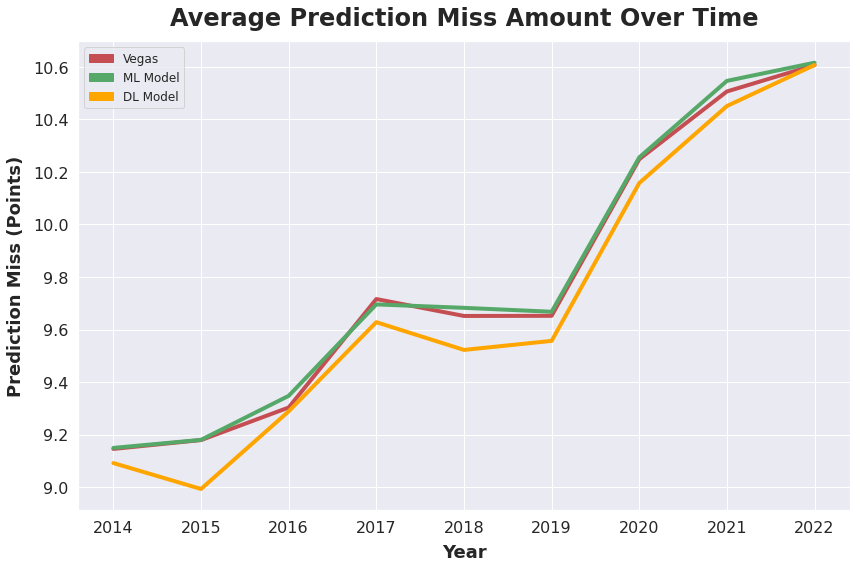

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=date_df, x='date', y='vegas_miss', ax=ax, color='r', linewidth=4)
sns.lineplot(data=date_df, x='date', y='model_miss_ml', ax=ax, color='g', linewidth=4)
sns.lineplot(data=date_df, x='date', y='model_miss_dl', ax=ax, color='orange', linewidth=4)

ax.set_title('Average Prediction Miss Amount Over Time', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Prediction Miss (Points)', fontsize=18, labelpad=8, fontweight='bold')

red_patch = mpatches.Patch(color='r', label='Vegas')
green_patch = mpatches.Patch(color='g', label='ML Model')
orange_patch = mpatches.Patch(color='orange', label='DL Model')
ax.legend(handles=[red_patch, green_patch, orange_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

In [37]:
date_df_2 = game_records.groupby([game_records.date.dt.year])

In [38]:
ml_win_pct_by_year = date_df_2['ml_model_v_vegas'].value_counts(normalize=True)[:, 'ml_model']
dl_win_pct_by_year = date_df_2['dl_model_v_vegas'].value_counts(normalize=True)[:, 'dl_model']

In [39]:
model_win_pct_by_year = pd.concat([ml_win_pct_by_year, dl_win_pct_by_year], axis=1).reset_index()

In [40]:
model_win_pct_by_year

,date,ml_model_v_vegas,dl_model_v_vegas
0,2014,0.50797,0.51936
1,2015,0.50293,0.53311
2,2016,0.48722,0.49876
3,2017,0.51303,0.50733
4,2018,0.48033,0.50879
5,2019,0.48384,0.52926
6,2020,0.48116,0.50000
7,2021,0.49467,0.51400
8,2022,0.50377,0.49516


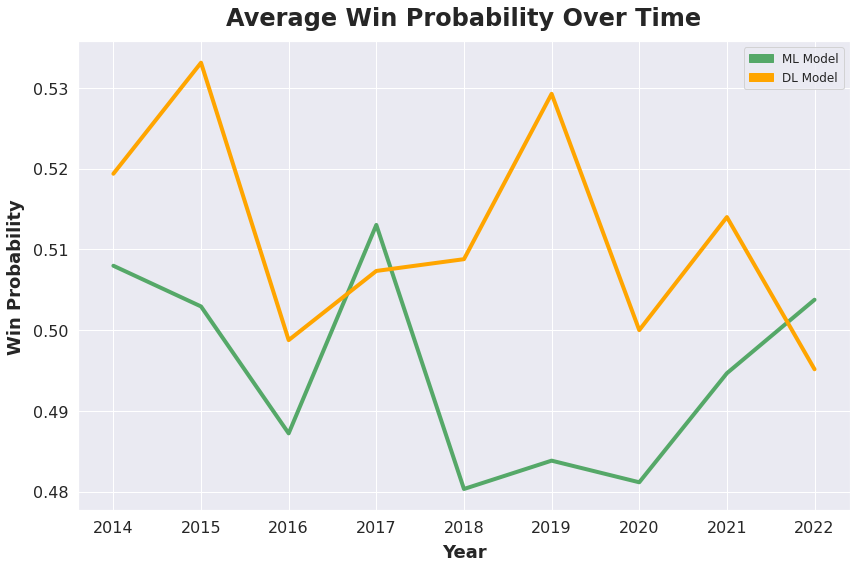

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=model_win_pct_by_year, x='date', y='ml_model_v_vegas', ax=ax, color='g', linewidth=4)
sns.lineplot(data=model_win_pct_by_year, x='date', y='dl_model_v_vegas',
             ax=ax, color='orange', linewidth=4)

ax.set_title('Average Win Probability Over Time', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Win Probability', fontsize=18, labelpad=8, fontweight='bold')

green_patch = mpatches.Patch(color='g', label='ML Model')
orange_patch = mpatches.Patch(color='orange', label='DL Model')
ax.legend(handles=[green_patch, orange_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id=dmpvpgp></a>

### Distributions of Model Predictions, Vegas Predictions, and Game Results 

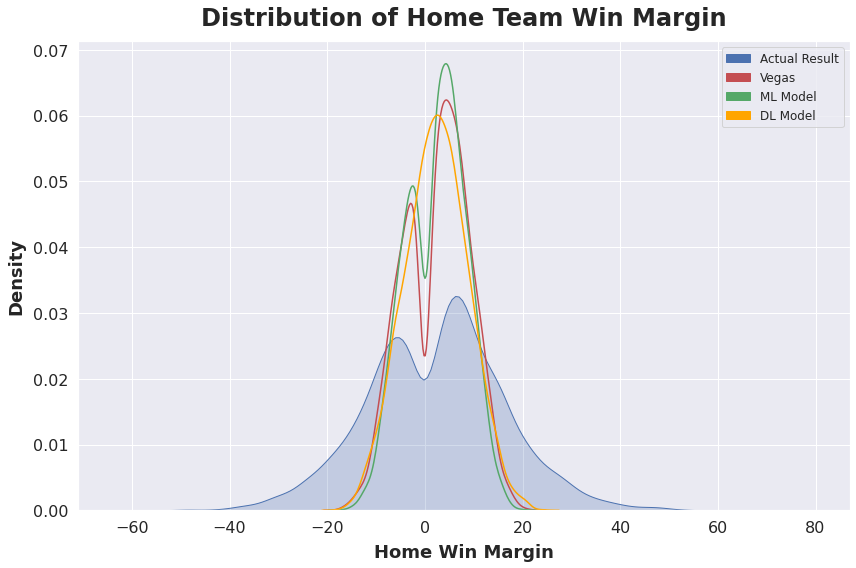

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
sns.kdeplot(data=game_records, x="game_result", ax=ax, color='b', fill=True)
sns.kdeplot(data=game_records, x="vegas_hv_pred", ax=ax, color='r', fill=False)
sns.kdeplot(data=game_records, x="ml_hv_pred", ax=ax, color='g', fill=False)
sns.kdeplot(data=game_records, x="dl_hv_pred", ax=ax, color='orange', fill=False)

ax.set_title('Distribution of Home Team Win Margin', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Home Win Margin', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Density', fontsize=18, labelpad=8, fontweight='bold')

blue_patch = mpatches.Patch(color='b', label='Actual Result')
red_patch = mpatches.Patch(color='r', label='Vegas')
green_patch = mpatches.Patch(color='g', label='ML Model')
orange_patch = mpatches.Patch(color='orange', label='DL Model')
ax.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id='owvlp'></a>

### Overall Winning vs. Losing Predictions
Must win 52.4% to overcome -110 vig

In [43]:
game_records['ml_model_v_vegas'].value_counts(normalize=False)

vegas       4763
ml_model    4663
Name: ml_model_v_vegas, dtype: int64

In [44]:
game_records['ml_model_v_vegas'].value_counts(normalize=True)

vegas       0.5053
ml_model    0.4947
Name: ml_model_v_vegas, dtype: float64

In [45]:
game_records['dl_model_v_vegas'].value_counts(normalize=False)

dl_model    4829
vegas       4597
Name: dl_model_v_vegas, dtype: int64

In [46]:
game_records['dl_model_v_vegas'].value_counts(normalize=True)

dl_model    0.51231
vegas       0.48769
Name: dl_model_v_vegas, dtype: float64

<a id='wpvpm'></a>

### Win Percentage vs. Prediction Margin

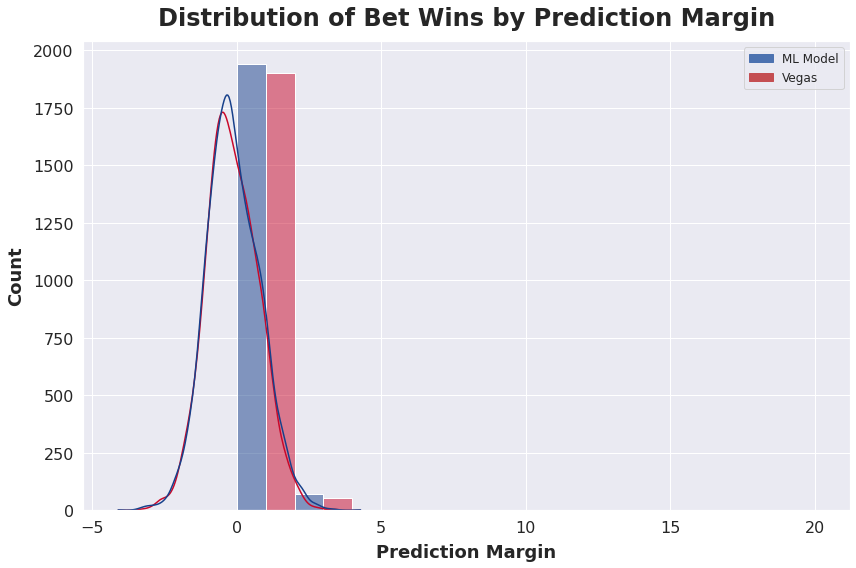

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data=game_records, x='ml_pred_line_margin',
             hue='ml_model_v_vegas', kde=True, ax=ax, bins=[0,2,4,6,8,10,15,20],
             palette=('#17408B', '#C9082A'), multiple='dodge')

ax.set_title('Distribution of Bet Wins by Prediction Margin', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Prediction Margin', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Count', fontsize=18, labelpad=8, fontweight='bold')

blue_patch = mpatches.Patch(color='b', label='ML Model')
red_patch = mpatches.Patch(color='r', label='Vegas')
ax.legend(handles=[blue_patch, red_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

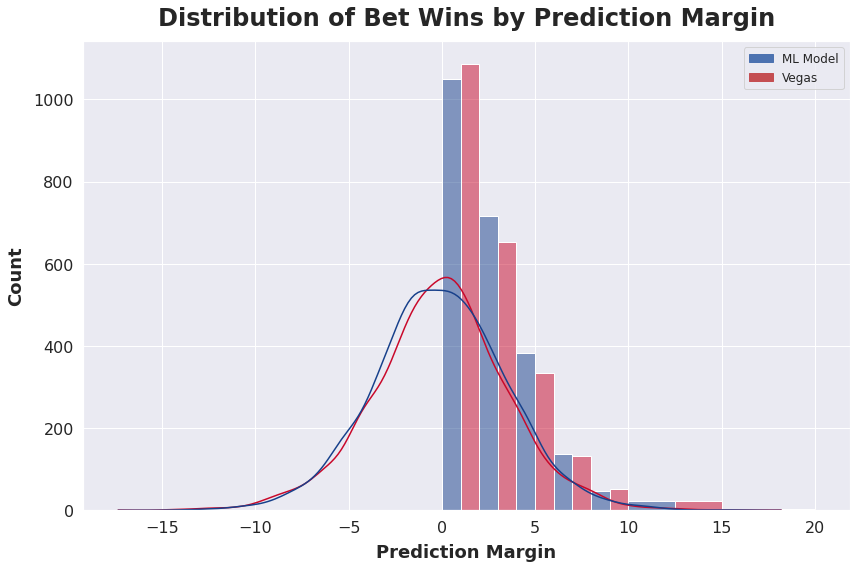

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data=game_records, x='dl_pred_line_margin',
             hue='dl_model_v_vegas', kde=True, ax=ax, bins=[0,2,4,6,8,10,15,20],
             palette=('#17408B', '#C9082A'), multiple='dodge')

ax.set_title('Distribution of Bet Wins by Prediction Margin', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Prediction Margin', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Count', fontsize=18, labelpad=8, fontweight='bold')

blue_patch = mpatches.Patch(color='b', label='ML Model')
red_patch = mpatches.Patch(color='r', label='Vegas')
ax.legend(handles=[blue_patch, red_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id=gscsa></a>

## Game Score and Component Score Accuracy

In [49]:
game_records['game_score_is_correct'] = game_records.apply(lambda x: x['game_score_direction'] 
                                                           if pd.isnull(x['game_score_direction']) 
                                                           else (x['game_score_direction'] == 
                                                                 x['game_result_direction']), axis=1)
game_records['ml_pred_is_correct'] = game_records.apply(lambda x: x['ml_pred_direction'] 
                                                           if pd.isnull(x['ml_pred_direction']) 
                                                           else (x['ml_pred_direction'] == 
                                                                 x['game_result_direction']), axis=1)
game_records['dl_pred_is_correct'] = game_records.apply(lambda x: x['dl_pred_direction'] 
                                                           if pd.isnull(x['dl_pred_direction']) 
                                                           else (x['dl_pred_direction'] == 
                                                                 x['game_result_direction']), axis=1)
game_records['covers_is_correct'] = game_records.apply(lambda x: x['covers_pred_direction'] 
                                                           if pd.isnull(x['covers_pred_direction']) 
                                                           else int(x['covers_pred_direction'] == 
                                                                 x['game_result_direction']), axis=1)
game_records['raptor_is_correct'] = game_records.apply(lambda x: x['raptor_pred_direction'] 
                                                           if pd.isnull(x['raptor_pred_direction']) 
                                                           else int(x['raptor_pred_direction'] == 
                                                                 x['game_result_direction']), axis=1)

In [50]:
# Date Restrictions
previous_years_only_df = game_records[game_records['date'] < datetime.strptime('20221001', "%Y%m%d")]
this_year_only_df = game_records[game_records['date'] > datetime.strptime('20221001', "%Y%m%d")]

<a id=overall></a>

### Overall Accuracy

In [51]:
game_score_accuracy = game_records['game_score_is_correct'].mean()
ml_pred_accuracy = game_records['ml_pred_is_correct'].mean()
dl_pred_accuracy = game_records['dl_pred_is_correct'].mean()
covers_accuracy = game_records['covers_is_correct'].mean()
raptor_accuracy = game_records['raptor_is_correct'].mean()

game_score_accuracy_py = previous_years_only_df['game_score_is_correct'].mean()
ml_pred_accuracy_py = previous_years_only_df['ml_pred_is_correct'].mean()
dl_pred_accuracy_py = previous_years_only_df['dl_pred_is_correct'].mean()
covers_accuracy_py = previous_years_only_df['covers_is_correct'].mean()
raptor_accuracy_py = previous_years_only_df['raptor_is_correct'].mean()

game_score_accuracy_ty = this_year_only_df['game_score_is_correct'].mean()
ml_pred_accuracy_ty = this_year_only_df['ml_pred_is_correct'].mean()
dl_pred_accuracy_ty = this_year_only_df['dl_pred_is_correct'].mean()
covers_accuracy_ty = this_year_only_df['covers_is_correct'].mean()
raptor_accuracy_ty = this_year_only_df['raptor_is_correct'].mean()

In [52]:
print('Game Score Accuracy')
print(f'Overall: {round(game_score_accuracy * 100, 2)}% - Previous Years: {round(game_score_accuracy_py * 100, 2)}% - This Year: {round(game_score_accuracy_ty * 100, 2)}%')
print('ML Pred Accuracy')
print(f'Overall: {round(ml_pred_accuracy * 100, 2)}% - Previous Years: {round(ml_pred_accuracy_py * 100, 2)}% - This Year: {round(ml_pred_accuracy_ty * 100, 2)}%')
print('DL Pred Accuracy')
print(f'Overall: {round(dl_pred_accuracy * 100, 2)}% - Previous Years: {round(dl_pred_accuracy_py * 100, 2)}% - This Year: {round(dl_pred_accuracy_ty * 100, 2)}%')
print('Covers Accuracy')
print(f'Overall: {round(covers_accuracy * 100, 2)}% - Previous Years: {round(covers_accuracy_py * 100, 2)}% - This Year: {round(covers_accuracy_ty * 100, 2)}%')
print('Raptor Accuracy')
print(f'Overall: {round(raptor_accuracy * 100, 2)}% - Previous Years: {round(raptor_accuracy_py * 100, 2)}% - This Year: {round(raptor_accuracy_ty * 100, 2)}%')

Game Score Accuracy
Overall: 66.68% - Previous Years: 67.11% - This Year: 49.12%
ML Pred Accuracy
Overall: 57.97% - Previous Years: 58.12% - This Year: 51.77%
DL Pred Accuracy
Overall: 68.6% - Previous Years: 69.13% - This Year: 46.9%
Covers Accuracy
Overall: 51.57% - Previous Years: 53.33% - This Year: 51.39%
Raptor Accuracy
Overall: 50.63% - Previous Years: 50.51% - This Year: 53.1%


In [53]:
x_data = ['Random Guess', 'Profitable', 'Game Score', 'ML Model', 'DL Model', 'Covers', 'Raptor']
y_data = [50.0,
          52.4,
          round(game_score_accuracy_ty * 100, 2),
          round(ml_pred_accuracy_ty * 100, 2),
          round(dl_pred_accuracy_ty * 100, 2),
          round(covers_accuracy_ty * 100, 2),
          round(raptor_accuracy_ty * 100, 2)]

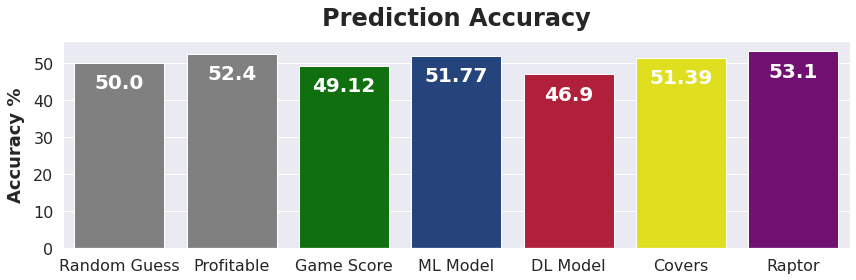

In [54]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.barplot(x=x_data, y=y_data,
             palette=('gray', 'gray', 'green', '#17408B', '#C9082A','yellow', 'purple'))

ax.set_title('Prediction Accuracy', fontsize=24, pad=16, fontweight='bold')
ax.set_ylabel('Accuracy %', fontsize=18, labelpad=8, fontweight='bold')

for p in ax.patches:
             ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=20, fontweight='bold', color='white', xytext=(0, -20),
                 textcoords='offset points')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

image_name = 'prediction_accuracy'
# plt.savefig(f'../images/{image_name}.png', dpi=300, bbox_inches='tight')

<a id=gamescore></a>

### Game Score Accuracy

In [55]:
overall_game_score_accuracy = game_records.groupby(pd.cut(game_records['game_score'],
                                                          bins=list(range(0, 100, 5))))['game_score_is_correct'].agg(['mean', 'size']).reset_index()
previous_years_game_score_accuracy = previous_years_only_df.groupby(pd.cut(previous_years_only_df['game_score'],
                                                          bins=list(range(0, 100, 5))))['game_score_is_correct'].agg(['mean', 'size']).reset_index()
this_year_game_score_accuracy = this_year_only_df.groupby(pd.cut(this_year_only_df['game_score'],
                                                          bins=list(range(0, 100, 5))))['game_score_is_correct'].agg(['mean', 'size']).reset_index()

In [56]:
overall_game_score_accuracy['bin_high'] = overall_game_score_accuracy['game_score'].apply(lambda x: x.right)
previous_years_game_score_accuracy['bin_high'] = previous_years_game_score_accuracy['game_score'].apply(lambda x: x.right)
this_year_game_score_accuracy['bin_high'] = this_year_game_score_accuracy['game_score'].apply(lambda x: x.right)

In [57]:
print(overall_game_score_accuracy, '\n\n', previous_years_game_score_accuracy, '\n\n', this_year_game_score_accuracy)

   game_score     mean  size bin_high
0      (0, 5]      NaN     0        5
1     (5, 10]      NaN     0       10
2    (10, 15]      NaN     0       15
3    (15, 20]      NaN     0       20
4    (20, 25]      NaN     0       25
5    (25, 30]      NaN     0       30
6    (30, 35]      NaN     0       35
7    (35, 40]      NaN     0       40
8    (40, 45]      NaN     0       45
9    (45, 50]      NaN     0       50
10   (50, 55]  0.55955  3871       55
11   (55, 60]  0.69446  2854       60
12   (60, 65]  0.77347  1651       65
13   (65, 70]  0.79810   738       70
14   (70, 75]  0.85903   227       75
15   (75, 80]  0.87500    72       80
16   (80, 85]  1.00000    13       85
17   (85, 90]      NaN     0       90
18   (90, 95]      NaN     0       95 

    game_score     mean  size bin_high
0      (0, 5]      NaN     0        5
1     (5, 10]      NaN     0       10
2    (10, 15]      NaN     0       15
3    (15, 20]      NaN     0       20
4    (20, 25]      NaN     0       25
5    (25,

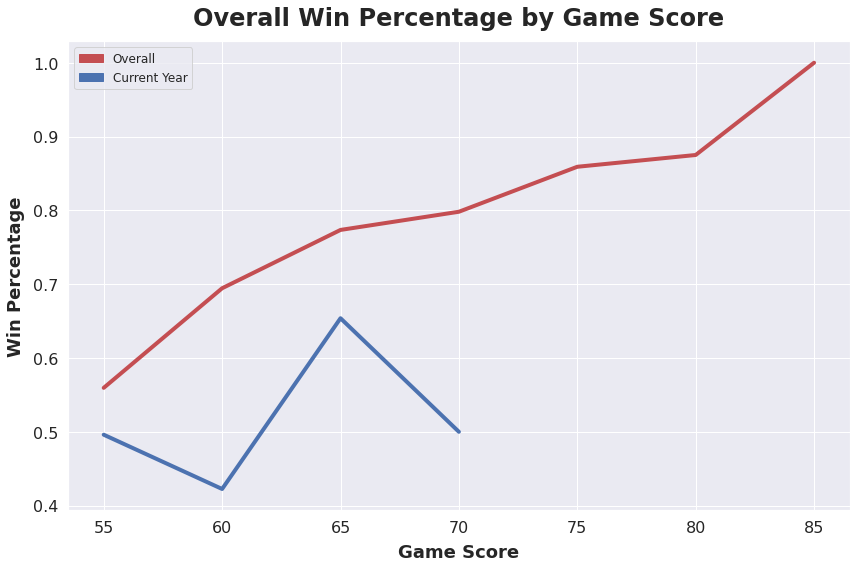

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=overall_game_score_accuracy, x='bin_high', y='mean', ax=ax, color='r', linewidth=4)
sns.lineplot(data=this_year_game_score_accuracy, x='bin_high', y='mean', ax=ax, color='b', linewidth=4)

ax.set_title('Overall Win Percentage by Game Score', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Game Score', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Win Percentage', fontsize=18, labelpad=8, fontweight='bold')

red_patch = mpatches.Patch(color='r', label='Overall')
blue_patch = mpatches.Patch(color='b', label='Current Year')
ax.legend(handles=[red_patch, blue_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id=ml></a>

### ML Prediction Accuracy

In [59]:
overall_ml_pred_accuracy = game_records.groupby(pd.cut(game_records['ml_home_score'],
                                                          bins=list(range(0, 100, 5))))['ml_pred_is_correct'].agg(['mean', 'size']).reset_index()
previous_years_ml_pred_accuracy = previous_years_only_df.groupby(pd.cut(previous_years_only_df['ml_home_score'],
                                                          bins=list(range(0, 100, 5))))['ml_pred_is_correct'].agg(['mean', 'size']).reset_index()
this_year_ml_pred_accuracy = this_year_only_df.groupby(pd.cut(this_year_only_df['ml_home_score'],
                                                          bins=list(range(0, 100, 5))))['ml_pred_is_correct'].agg(['mean', 'size']).reset_index()

In [60]:
overall_ml_pred_accuracy['bin_high'] = overall_ml_pred_accuracy['ml_home_score'].apply(lambda x: x.right)
previous_years_ml_pred_accuracy['bin_high'] = previous_years_ml_pred_accuracy['ml_home_score'].apply(lambda x: x.right)
this_year_ml_pred_accuracy['bin_high'] = this_year_ml_pred_accuracy['ml_home_score'].apply(lambda x: x.right)

In [61]:
print(overall_ml_pred_accuracy, '\n\n', previous_years_ml_pred_accuracy, '\n\n', this_year_ml_pred_accuracy)

   ml_home_score     mean  size bin_high
0         (0, 5]      NaN     0        5
1        (5, 10]      NaN     0       10
2       (10, 15]  0.50000     4       15
3       (15, 20]  0.84211    19       20
4       (20, 25]  0.81579    76       25
5       (25, 30]  0.69907   216       30
6       (30, 35]  0.63834   459       35
7       (35, 40]  0.59977   887       40
8       (40, 45]  0.56691  1390       45
9       (45, 50]  0.52304  1671       50
10      (50, 55]  0.54435  1725       55
11      (55, 60]  0.55074  1360       60
12      (60, 65]  0.62924   855       65
13      (65, 70]  0.64837   492       70
14      (70, 75]  0.71921   203       75
15      (75, 80]  0.78182    55       80
16      (80, 85]  0.84615    13       85
17      (85, 90]  1.00000     1       90
18      (90, 95]      NaN     0       95 

    ml_home_score     mean  size bin_high
0         (0, 5]      NaN     0        5
1        (5, 10]      NaN     0       10
2       (10, 15]  0.50000     4       15
3       (15, 

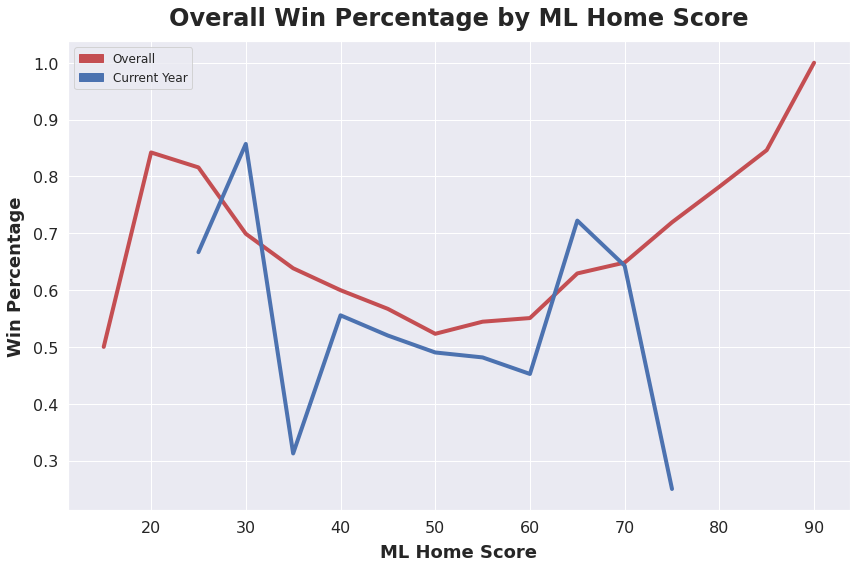

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=overall_ml_pred_accuracy, x='bin_high', y='mean', ax=ax, color='r', linewidth=4)
sns.lineplot(data=this_year_ml_pred_accuracy, x='bin_high', y='mean', ax=ax, color='b', linewidth=4)

ax.set_title('Overall Win Percentage by ML Home Score', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('ML Home Score', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Win Percentage', fontsize=18, labelpad=8, fontweight='bold')

red_patch = mpatches.Patch(color='r', label='Overall')
blue_patch = mpatches.Patch(color='b', label='Current Year')
ax.legend(handles=[red_patch, blue_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id=dl></a>

### DL Prediction Accuracy

In [63]:
overall_dl_pred_accuracy = game_records.groupby(pd.cut(game_records['dl_home_score'],
                                                          bins=list(range(0, 100, 5))))['dl_pred_is_correct'].agg(['mean', 'size']).reset_index()
previous_years_dl_pred_accuracy = previous_years_only_df.groupby(pd.cut(previous_years_only_df['dl_home_score'],
                                                          bins=list(range(0, 100, 5))))['dl_pred_is_correct'].agg(['mean', 'size']).reset_index()
this_year_dl_pred_accuracy = this_year_only_df.groupby(pd.cut(this_year_only_df['dl_home_score'],
                                                          bins=list(range(0, 100, 5))))['dl_pred_is_correct'].agg(['mean', 'size']).reset_index()

In [64]:
overall_dl_pred_accuracy['bin_high'] = overall_dl_pred_accuracy['dl_home_score'].apply(lambda x: x.right)
previous_years_dl_pred_accuracy['bin_high'] = previous_years_dl_pred_accuracy['dl_home_score'].apply(lambda x: x.right)
this_year_dl_pred_accuracy['bin_high'] = this_year_dl_pred_accuracy['dl_home_score'].apply(lambda x: x.right)

In [65]:
print(overall_dl_pred_accuracy, '\n\n', previous_years_dl_pred_accuracy, '\n\n', this_year_dl_pred_accuracy)

   dl_home_score     mean  size bin_high
0         (0, 5]      NaN     0        5
1        (5, 10]  0.80000     5       10
2       (10, 15]  0.81818    44       15
3       (15, 20]  0.85430   151       20
4       (20, 25]  0.83548   310       25
5       (25, 30]  0.82037   540       30
6       (30, 35]  0.74638   690       35
7       (35, 40]  0.68207   887       40
8       (40, 45]  0.64271   988       45
9       (45, 50]  0.53486  1133       50
10      (50, 55]  0.54697  1022       55
11      (55, 60]  0.63654  1029       60
12      (60, 65]  0.72301   917       65
13      (65, 70]  0.75937   694       70
14      (70, 75]  0.79290   507       75
15      (75, 80]  0.83039   283       80
16      (80, 85]  0.83117   154       85
17      (85, 90]  0.89231    65       90
18      (90, 95]  1.00000     7       95 

    dl_home_score     mean  size bin_high
0         (0, 5]      NaN     0        5
1        (5, 10]  0.80000     5       10
2       (10, 15]  0.83721    43       15
3       (15, 

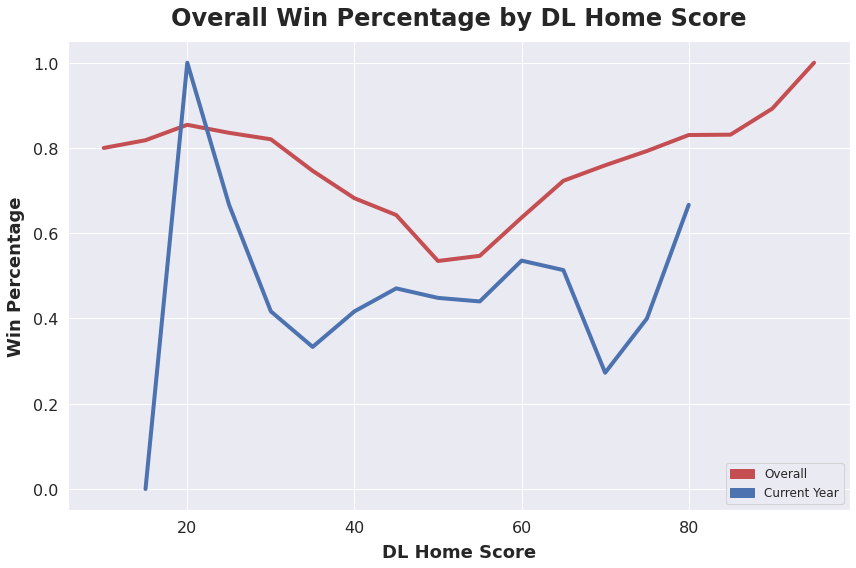

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=overall_dl_pred_accuracy, x='bin_high', y='mean', ax=ax, color='r', linewidth=4)
sns.lineplot(data=this_year_dl_pred_accuracy, x='bin_high', y='mean', ax=ax, color='b', linewidth=4)

ax.set_title('Overall Win Percentage by DL Home Score', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('DL Home Score', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Win Percentage', fontsize=18, labelpad=8, fontweight='bold')

red_patch = mpatches.Patch(color='r', label='Overall')
blue_patch = mpatches.Patch(color='b', label='Current Year')
ax.legend(handles=[red_patch, blue_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id=covers></a>

### Covers Accuracy

In [67]:
overall_covers_accuracy = game_records.groupby(pd.cut(game_records['covers_home_score'],
                                                          bins=list(range(0, 100, 5))))['covers_is_correct'].agg(['mean', 'size']).reset_index()
previous_years_covers_accuracy = previous_years_only_df.groupby(pd.cut(previous_years_only_df['covers_home_score'],
                                                          bins=list(range(0, 100, 5))))['covers_is_correct'].agg(['mean', 'size']).reset_index()
this_year_covers_accuracy = this_year_only_df.groupby(pd.cut(this_year_only_df['covers_home_score'],
                                                          bins=list(range(0, 100, 5))))['covers_is_correct'].agg(['mean', 'size']).reset_index()

In [68]:
overall_covers_accuracy['bin_high'] = overall_covers_accuracy['covers_home_score'].apply(lambda x: x.right)
previous_years_covers_accuracy['bin_high'] = previous_years_covers_accuracy['covers_home_score'].apply(lambda x: x.right)
this_year_covers_accuracy['bin_high'] = this_year_covers_accuracy['covers_home_score'].apply(lambda x: x.right)

In [69]:
print(overall_covers_accuracy, '\n\n', previous_years_covers_accuracy, '\n\n', this_year_covers_accuracy)

   covers_home_score     mean  size bin_high
0             (0, 5]      NaN     0        5
1            (5, 10]      NaN     0       10
2           (10, 15]      NaN     0       15
3           (15, 20]      NaN     0       20
4           (20, 25]      NaN     0       25
5           (25, 30]  0.50000     2       30
6           (30, 35]  0.26667    15       35
7           (35, 40]  0.56250    16       40
8           (40, 45]  0.68421    19       45
9           (45, 50]  0.47059    17       50
10          (50, 55]  0.69231    13       55
11          (55, 60]  0.54286    35       60
12          (60, 65]  0.57143    21       65
13          (65, 70]  0.18182    11       70
14          (70, 75]  0.50000    10       75
15          (75, 80]      NaN     0       80
16          (80, 85]      NaN     0       85
17          (85, 90]      NaN     0       90
18          (90, 95]      NaN     0       95 

    covers_home_score     mean  size bin_high
0             (0, 5]      NaN     0        5
1      

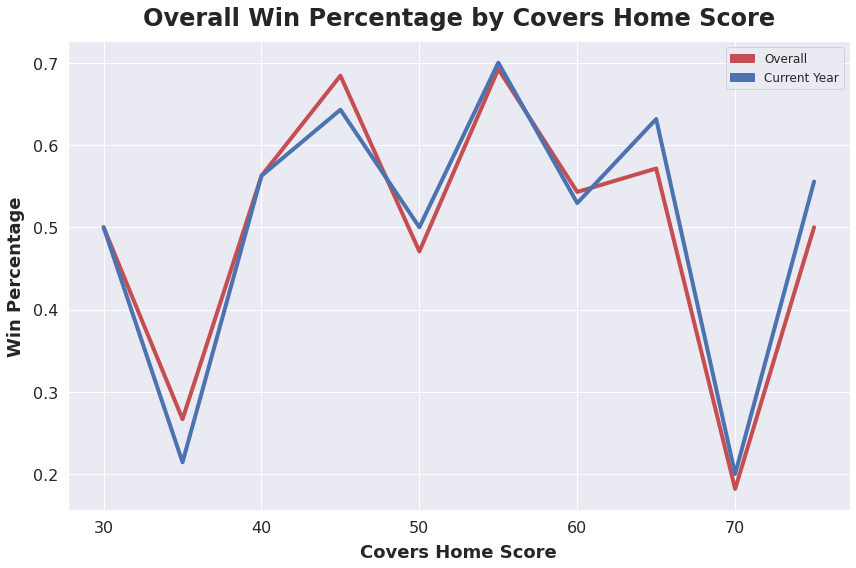

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=overall_covers_accuracy, x='bin_high', y='mean', ax=ax, color='r', linewidth=4)
sns.lineplot(data=this_year_covers_accuracy, x='bin_high', y='mean', ax=ax, color='b', linewidth=4)

ax.set_title('Overall Win Percentage by Covers Home Score', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Covers Home Score', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Win Percentage', fontsize=18, labelpad=8, fontweight='bold')

red_patch = mpatches.Patch(color='r', label='Overall')
blue_patch = mpatches.Patch(color='b', label='Current Year')
ax.legend(handles=[red_patch, blue_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

<a id=raptor></a>

### Raptor Accuracy

In [71]:
overall_raptor_accuracy = game_records.groupby(pd.cut(game_records['raptor_home_score'],
                                                          bins=list(range(0, 100, 5))))['raptor_is_correct'].agg(['mean', 'size']).reset_index()
previous_years_raptor_accuracy = previous_years_only_df.groupby(pd.cut(previous_years_only_df['raptor_home_score'],
                                                          bins=list(range(0, 100, 5))))['raptor_is_correct'].agg(['mean', 'size']).reset_index()
this_year_raptor_accuracy = this_year_only_df.groupby(pd.cut(this_year_only_df['raptor_home_score'],
                                                          bins=list(range(0, 100, 5))))['raptor_is_correct'].agg(['mean', 'size']).reset_index()

In [72]:
overall_raptor_accuracy['bin_high'] = overall_raptor_accuracy['raptor_home_score'].apply(lambda x: x.right)
previous_years_raptor_accuracy['bin_high'] = previous_years_raptor_accuracy['raptor_home_score'].apply(lambda x: x.right)
this_year_raptor_accuracy['bin_high'] = this_year_raptor_accuracy['raptor_home_score'].apply(lambda x: x.right)

In [73]:
print(overall_raptor_accuracy, '\n\n', previous_years_raptor_accuracy, '\n\n', this_year_raptor_accuracy)

   raptor_home_score     mean  size bin_high
0             (0, 5]  1.00000     1        5
1            (5, 10]  0.00000     1       10
2           (10, 15]  0.00000     1       15
3           (15, 20]      NaN     0       20
4           (20, 25]  0.50000    10       25
5           (25, 30]  0.43750    16       30
6           (30, 35]  0.57143    56       35
7           (35, 40]  0.48438   128       40
8           (40, 45]  0.53495   329       45
9           (45, 50]  0.49686   795       50
10          (50, 55]  0.49740  1154       55
11          (55, 60]  0.49953  1073       60
12          (60, 65]  0.52574   641       65
13          (65, 70]  0.51546   291       70
14          (70, 75]  0.48148   108       75
15          (75, 80]  0.65116    43       80
16          (80, 85]  0.42857    14       85
17          (85, 90]  0.40000     5       90
18          (90, 95]      NaN     0       95 

    raptor_home_score     mean  size bin_high
0             (0, 5]  1.00000     1        5
1      

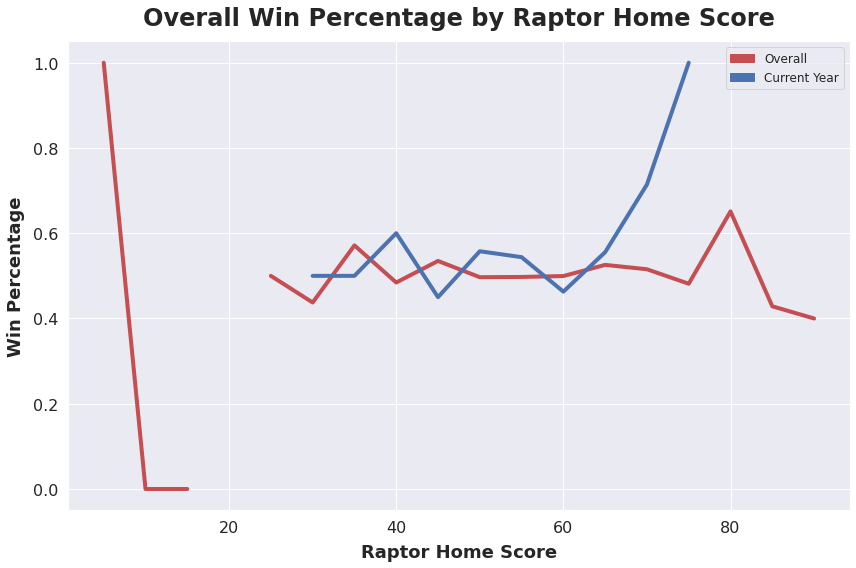

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=overall_raptor_accuracy, x='bin_high', y='mean', ax=ax, color='r', linewidth=4)
sns.lineplot(data=this_year_raptor_accuracy, x='bin_high', y='mean', ax=ax, color='b', linewidth=4)

ax.set_title('Overall Win Percentage by Raptor Home Score', fontsize=24, pad=16, fontweight='bold')
ax.set_xlabel('Raptor Home Score', fontsize=18, labelpad=8, fontweight='bold')
ax.set_ylabel('Win Percentage', fontsize=18, labelpad=8, fontweight='bold')

red_patch = mpatches.Patch(color='r', label='Overall')
blue_patch = mpatches.Patch(color='b', label='Current Year')
ax.legend(handles=[red_patch, blue_patch], fontsize='large')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()